### Обнаружение статистически значимых отличий в уровнях экспрессии генов больных раком

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import scipy 

from statsmodels.sandbox.stats.multicomp import multipletests 
import statsmodels.stats.multitest as smm

import warnings
warnings.filterwarnings('ignore')

Данные для этой задачи взяты из исследования, проведенного в Stanford School of Medicine. В исследовании была предпринята попытка выявить набор генов, которые позволили бы более точно диагностировать возникновение рака груди на самых ранних стадиях.

В эксперименте принимали участие 24 человек, у которых не было рака груди (normal), 25 человек, у которых это заболевание было диагностировано на ранней стадии (early neoplasia), и 23 человека с сильно выраженными симптомами (cancer).

Ученые провели секвенирование биологического материала испытуемых, чтобы понять, какие из этих генов наиболее активны в клетках больных людей.

Секвенирование — это определение степени активности генов в анализируемом образце с помощью подсчёта количества соответствующей каждому гену РНК.

В данных для этого задания вы найдете именно эту количественную меру активности каждого из 15748 генов у каждого из 72 человек, принимавших участие в эксперименте.

Вам нужно будет определить те гены, активность которых у людей в разных стадиях заболевания отличается статистически значимо.

Кроме того, вам нужно будет оценить не только статистическую, но и практическую значимость этих результатов, которая часто используется в подобных исследованиях.

Диагноз человека содержится в столбце под названием "Diagnosis".

In [2]:
genes = pd.read_csv('gene_high_throughput_sequencing.csv')
genes.shape

(72, 15750)

In [3]:
genes.describe()

,LOC643837,LOC100130417,SAMD11,NOC2L,KLHL17,PLEKHN1,C1orf170,HES4,ISG15,AGRN,...,CLIC2,RPS4Y1,ZFY,PRKY,USP9Y,DDX3Y,CD24,CYorf15B,KDM5D,EIF1AY
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,...,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,2.463922,7.100958,19.056151,15.618688,23.537120,11.303466,8.921396,63.270147,53.906324,70.678573,...,5.563444,2.192029,1.967424,2.181360,1.729308,1.980733,16.834075,1.825827,2.287380,1.756827
std,1.413687,4.164703,9.287753,4.664146,4.475294,4.055122,3.270713,13.792140,45.635498,21.326237,...,2.389789,2.454218,2.047129,2.542652,1.507149,2.230157,7.126802,1.902716,3.185571,1.623151
min,0.833898,1.231043,4.941211,6.395270,8.520713,2.066576,1.364917,42.544976,24.616767,42.631422,...,1.144240,0.853957,0.853957,0.853957,0.833898,0.833898,4.675683,0.833898,0.853957,0.833898
25%,1.284642,3.892403,13.423946,12.574596,21.151624,8.712898,6.213396,53.093627,34.009687,54.202100,...,3.805875,1.042783,1.011350,1.011350,1.003337,1.003337,11.186633,1.003337,1.011350,1.003337
50%,2.104677,6.315551,16.734855,14.586150,23.477006,11.172590,8.703397,63.230911,39.554954,65.510651,...,5.617824,1.339507,1.273861,1.298543,1.252527,1.252527,16.514389,1.252527,1.273861,1.252527
75%,3.345067,8.916399,21.884325,17.695678,26.471909,13.568625,11.139240,69.880705,50.295756,79.427207,...,7.100942,1.815754,1.647255,1.677971,1.625364,1.611299,21.849385,1.607345,1.647255,1.611299
max,7.364879,20.006038,60.584449,29.659104,34.110743,27.441093,17.121366,132.144503,327.590426,128.606260,...,11.227770,11.913855,10.883310,11.692697,10.392539,10.640754,49.295538,9.919132,17.278985,9.333904


In [4]:
genes.head()

,Patient_id,Diagnosis,LOC643837,LOC100130417,SAMD11,NOC2L,KLHL17,PLEKHN1,C1orf170,HES4,...,CLIC2,RPS4Y1,ZFY,PRKY,USP9Y,DDX3Y,CD24,CYorf15B,KDM5D,EIF1AY
0,STT5425_Breast_001_normal,normal,1.257614,2.408148,13.368622,9.494779,20.880435,12.722017,9.494779,54.349694,...,4.761250,1.257614,1.257614,1.257614,1.257614,1.257614,23.268694,1.257614,1.257614,1.257614
1,STT5427_Breast_023_normal,normal,4.567931,16.602734,42.477752,25.562376,23.221137,11.622386,14.330573,72.445474,...,6.871902,1.815112,1.815112,1.815112,1.815112,1.815112,10.427023,1.815112,1.815112,1.815112
2,STT5430_Breast_002_normal,normal,2.077597,3.978294,12.863214,13.728915,14.543176,14.141907,6.232790,57.011005,...,7.096343,2.077597,2.077597,2.077597,2.077597,2.077597,22.344226,2.077597,2.077597,2.077597
3,STT5439_Breast_003_normal,normal,2.066576,8.520713,14.466035,7.823932,8.520713,2.066576,10.870009,53.292034,...,5.200770,2.066576,2.066576,2.066576,2.066576,2.066576,49.295538,2.066576,2.066576,2.066576
4,STT5441_Breast_004_normal,normal,2.613616,3.434965,12.682222,10.543189,26.688686,12.484822,1.364917,67.140393,...,11.227770,1.364917,1.364917,1.364917,1.364917,1.364917,23.627911,1.364917,1.364917,1.364917


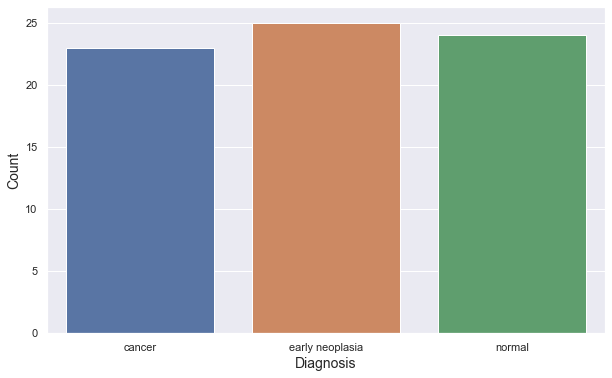

In [5]:
plt.figure(figsize=(10,6))
diagnosis, count = np.unique(genes.Diagnosis, return_counts=True)
sns.barplot(diagnosis, count)
plt.xlabel('Diagnosis', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

### 1. Часть 1: применение t-критерия Стьюдента

В первой части вам нужно будет применить критерий Стьюдента для проверки гипотезы о равенстве средних в двух независимых выборках. Применить критерий для каждого гена нужно будет дважды:

- для групп normal (control) и early neoplasia (treatment)
- для групп early neoplasia (control) и cancer (treatment)

В качестве ответа в этой части задания необходимо указать количество статистически значимых отличий, которые вы нашли с помощью t-критерия Стьюдента, то есть число генов, у которых p-value этого теста оказался меньше, чем уровень значимости. 

In [6]:
#Split data by two groups: (normal, early_neoplasia) and (early_neoplasia, cancer)

normal = genes[genes.Diagnosis == 'normal']
early_neoplasia = genes[genes.Diagnosis == 'early neoplasia']
cancer = genes[genes.Diagnosis == 'cancer']

normal_data = normal.iloc[:, 2:]
early_neoplasia_data = early_neoplasia.iloc[:, 2:]
cancer_data = cancer.iloc[:, 2:]

In [7]:
# Student t-Test for equality of two means in group 1

test_norm_neoplasia = scipy.stats.ttest_ind(normal_data, early_neoplasia_data, equal_var=False)
p_group1 = list(test_norm_neoplasia[1])
test_norm_neoplasia

Ttest_indResult(statistic=array([ 0.40028856, -4.60876561, -1.92927671, ..., -0.42874732,
       -0.26290994, -0.44141971]), pvalue=array([6.90766016e-01, 3.17853128e-05, 6.02726639e-02, ...,
       6.70394526e-01, 7.93924592e-01, 6.61031158e-01]))

In [8]:
# Student t-Test for equality of two means in group 2

test_neoplasia_cancer = scipy.stats.ttest_ind(early_neoplasia_data, cancer_data, equal_var=False)
p_group2 = list(test_neoplasia_cancer[1])
test_neoplasia_cancer

Ttest_indResult(statistic=array([ 0.82484898,  0.45223643, -1.81726605, ..., -0.61369626,
       -0.57920878, -0.47298651]), pvalue=array([0.41373532, 0.65342892, 0.07955556, ..., 0.54293926, 0.56575284,
       0.63900998]))

In [9]:
def write_answer(filename, answer):
    with open(filename, 'w') as fout:
        fout.write(str(answer))
        fout.close()

# Count statistically significant genes where p < 0.05
count_gr_1 = sum(p < 0.05 for p in p_group1)
count_gr_2 = sum(p < 0.05 for p in p_group2)

print(f'Number of genes for group 1 where p-value < 0.05 for i-th gene: {count_gr_1}')
print(f'Number of genes for group 2 where p-value < 0.05 for i-th gene: {count_gr_2}')
write_answer('submission_1.txt', count_gr_1)
write_answer('submission_2.txt', count_gr_2)

Number of genes for group 1 where p-value < 0.05 for i-th gene: 1575
Number of genes for group 2 where p-value < 0.05 for i-th gene: 3490


### 2. Часть 2: поправка методом Холма

В этой части задания нужно будет применить поправку Холма для получившихся двух наборов достигаемых уровней значимости из предыдущей части. Обратите внимание, что поскольку вы будете делать поправку для каждого из двух наборов p-value отдельно, то проблема, связанная с множественной проверкой останется.

Для того, чтобы ее устранить, достаточно воспользоваться поправкой Бонферрони, то есть использовать уровень значимости $0.05$ / $2$ вместо $0.05$ для дальнейшего уточнения значений p-value c помощью метода Холма.

В качестве ответа к этому заданию требуется ввести количество значимых отличий в каждой группе после того, как произведена коррекция Холма-Бонферрони. Причем это число нужно ввести с учетом практической значимости: посчитайте для каждого значимого изменения fold change и выпишите в ответ число таких значимых изменений, абсолютное значение fold change которых больше, чем $1.5$


<b>Обратите внимание, что:</b>

- применять поправку на множественную проверку нужно ко всем значениям достигаемых уровней значимости, а не только для тех, которые меньше значения уровня доверия.
- при использовании поправки на уровне значимости $0.025$ меняются значения достигаемого уровня значимости, но не меняется значение уровня доверия (то есть для отбора значимых изменений скорректированные значения уровня значимости нужно сравнивать с порогом $0.025$, а не $0.05$)! 

In [10]:
def fold_change(C, T):    
    '''
    C - control sample
    T - treatment sample
    
    C, T — средние значения экспрессии гена в control и treatment группах соответственно. 
    По сути, fold change показывает, во сколько раз отличаются средние двух выборок  
    '''    
    return T / C if T >= C else -C / T

# Holm correction
reject_1, normal_neoplasia_p, a1_1, a2_1 = multipletests(p_group1, method='holm')
reject_2, neoplasia_cancer_p, a1_2, a2_2 = multipletests(p_group2, method='holm')

# Bonferroni correction
p_values = np.array([normal_neoplasia_p, neoplasia_cancer_p])

reject_3, p_holm_bonf, a1_3, a2_3 = multipletests(p_values, is_sorted=True, method='bonferroni')

# Count statistically significant genes where p < 0.05 after holm-bonferroni correction
count_gr_1 = sum(p < 0.05 for p in p_holm_bonf[0])
count_gr_2 = sum(p < 0.05 for p in p_holm_bonf[1])

print(f'Number of genes for group 1 where p-value < 0.05 for i-th gene: {count_gr_1}')
print(f'Number of genes for group 2 where p-value < 0.05 for i-th gene: {count_gr_2}')    

Number of genes for group 1 where p-value < 0.05 for i-th gene: 2
Number of genes for group 2 where p-value < 0.05 for i-th gene: 79


In [11]:
count_fold_gr_1, count_fold_gr_2 = 0, 0

p_holm_bonf_normal_gr_1 = normal_data.iloc[:, np.where(p_holm_bonf[0] < 0.05)[0]]
p_holm_bonf_neoplasia_gr_1 = early_neoplasia_data.iloc[:, np.where(p_holm_bonf[0] < 0.05)[0]]
p_holm_bonf_neoplasia_gr_2 = early_neoplasia_data.iloc[:, np.where(p_holm_bonf[1] < 0.05)[0]]
p_holm_bonf_cancer_gr_2 = cancer_data.iloc[:, np.where(p_holm_bonf[1] < 0.05)[0]]

# Count where fold_change > 1.5 in absolute value
for normal, neoplasia in zip(p_holm_bonf_normal_gr_1.mean(), p_holm_bonf_neoplasia_gr_1.mean()):
    if np.abs(fold_change(normal, neoplasia)) > 1.5: 
        count_fold_gr_1 += 1

for neoplasia, cancer in zip(p_holm_bonf_neoplasia_gr_2.mean(), p_holm_bonf_cancer_gr_2.mean()):
    if np.abs(fold_change(neoplasia, cancer)) > 1.5: 
        count_fold_gr_2 += 1

print(f'Number of genes for group 1 where p-value < 0.05 for i-th gene and fold change > 1.5: {count_fold_gr_1}')
print(f'Number of genes for group 2 where p-value < 0.05 for i-th gene  and fold change > 1.5: {count_fold_gr_2}')

write_answer('submission_3.txt', count_fold_gr_1)
write_answer('submission_4.txt', count_fold_gr_2)

Number of genes for group 1 where p-value < 0.05 for i-th gene and fold change > 1.5: 2
Number of genes for group 2 where p-value < 0.05 for i-th gene  and fold change > 1.5: 77


### 3. Часть 3: поправка методом Бенджамини-Хохберга

Данная часть задания аналогична второй части за исключением того, что нужно будет использовать метод Бенджамини-Хохберга.

Обратите внимание, что методы коррекции, которые контролируют <b>FDR</b>, допускает больше ошибок первого рода и имеют большую мощность, чем методы, контролирующие <b>FWER</b>. Большая мощность означает, что эти методы будут совершать меньше ошибок второго рода (то есть будут лучше улавливать отклонения от $H_0$, когда они есть, и будут чаще отклонять $H_0$, когда отличий нет).

В качестве ответа к этому заданию требуется ввести количество значимых отличий в каждой группе после того, как произведена коррекция Бенджамини-Хохберга, причем так же, как и во второй части, считать только такие отличия, у которых $|{fold}_{change}| > 1.5$. 

In [12]:
# Benjamini/Hochberg correction
reject_1, normal_neoplasia_p, a1_1, a2_1 = multipletests(p_group1, method='fdr_bh')
reject_2, neoplasia_cancer_p, a1_2, a2_2 = multipletests(p_group2, method='fdr_bh')

# Bonferroni correction
p_values = np.array([normal_neoplasia_p, neoplasia_cancer_p])

reject_3, p_holm_bonf, a1_3, a2_3 = multipletests(p_values, is_sorted=True, method='bonferroni')

# Count statistically significant genes where p < 0.05 after holm-bonferroni correction
count_gr_1 = sum(p < 0.05 for p in p_holm_bonf[0])
count_gr_2 = sum(p < 0.05 for p in p_holm_bonf[1])

print(f'Number of genes for group 1 where p-value < 0.05 for i-th gene: {count_gr_1}')
print(f'Number of genes for group 2 where p-value < 0.05 for i-th gene: {count_gr_2}')  

Number of genes for group 1 where p-value < 0.05 for i-th gene: 4
Number of genes for group 2 where p-value < 0.05 for i-th gene: 832


In [13]:
count_fold_gr_1_fdr_bh, count_fold_gr_2_fdr_bh = 0, 0

p_holm_bonf_normal_gr_1 = normal_data.iloc[:, np.where(p_holm_bonf[0] < 0.05)[0]]
p_holm_bonf_neoplasia_gr_1 = early_neoplasia_data.iloc[:, np.where(p_holm_bonf[0] < 0.05)[0]]
p_holm_bonf_neoplasia_gr_2 = early_neoplasia_data.iloc[:, np.where(p_holm_bonf[1] < 0.05)[0]]
p_holm_bonf_cancer_gr_2 = cancer_data.iloc[:, np.where(p_holm_bonf[1] < 0.05)[0]]

# Count where fold_change > 1.5 in absolute value

for normal, neoplasia in zip(p_holm_bonf_normal_gr_1.mean(), p_holm_bonf_neoplasia_gr_1.mean()):
    if np.abs(fold_change(normal, neoplasia)) > 1.5: 
        count_fold_gr_1_fdr_bh += 1

for neoplasia, cancer in zip(p_holm_bonf_neoplasia_gr_2.mean(), p_holm_bonf_cancer_gr_2.mean()):
    if np.abs(fold_change(neoplasia, cancer)) > 1.5: 
        count_fold_gr_2_fdr_bh += 1

print(f'Number of genes for group 1 where p-value < 0.05 for i-th gene and fold change > 1.5: {count_fold_gr_1_fdr_bh}')
print(f'Number of genes for group 2 where p-value < 0.05 for i-th gene  and fold change > 1.5: {count_fold_gr_2_fdr_bh}')

write_answer('submission_5.txt', count_fold_gr_1_fdr_bh)
write_answer('submission_6.txt', count_fold_gr_2_fdr_bh)

Number of genes for group 1 where p-value < 0.05 for i-th gene and fold change > 1.5: 4
Number of genes for group 2 where p-value < 0.05 for i-th gene  and fold change > 1.5: 524
